# 1.3 Attribution evaluation
selectivity evaluation for grad*input method

In [0]:
import torch
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
import pickle
import random

from basic_cnn import convnet
from vanilla_backprop import VanillaBackprop
from utils import *

In [0]:
net = convnet()
net.load_state_dict(torch.load('mnist_convnet.pth'))

with open('mnist_testdata.pickle', 'rb') as f:
    dataset = pickle.load(f)

VBP = VanillaBackprop(net)

### selectivity

In [0]:
total_steps = 50
step_acc_list = []

sample_num = 50
sample_indices = random.sample(range(10000), k=sample_num)

sample_images = [[] for i in range(sample_num)]
sample_grads = [[] for i in range(sample_num)]
sample_scores = [[] for i in range(sample_num)]

In [14]:
image_record.data = dataset.data.clone()

for i in range(total_steps):
    # number of images classified correctly after masking
    correct_count = 0

    # for j in range(100):
    for j in range(len(dataset)):
        image = image_record[j]
        image = image[None, None].type('torch.FloatTensor')
        image = Variable(image, requires_grad=True)
        
        target = dataset.targets[j]
        output = net(image)
        grads = VBP.generate_gradients(image, target)
        
        if output.argmax().item() == target.item():
            correct_count += 1
        
        image = image.detach().numpy()
        output = output.detach().numpy()
        
        # remove redundant dimensions
        image = image.squeeze()
        grads = grads.squeeze()
        
        # grad*input method
        grads = np.multiply(grads, image)
        
        # delete pixel with maximum gradient
        row, col = find_max_index(grads)
        image[row][col] = 0

        if j in sample_indices:
            # index of j in sample_indices
            j_index = sample_indices.index(j)
            # score for correct class
            score = output[0][target.item()].item()  # output is 1x10 tensor
            score = score / np.linalg.norm(output[0])   # normalize

            if i in [19, 49]:       # 20th, 50th iteration
                sample_images[j_index].append(image)
                sample_grads[j_index].append(grads)
            
            sample_scores[j_index].append(score)
        
        image = torch.tensor(image)
        image_record[j] = image
    
    # average accuracy
    acc = correct_count / len(dataset) * 100
    step_acc_list.append(acc)
    
    if (i+1)%10 == 0:
        print('epoch ' + str(i+1) + ': ' + str(acc))


epoch 10: 71.23
epoch 20: 38.35
epoch 30: 16.61
epoch 40: 6.4799999999999995
epoch 50: 2.37


### average accuracy

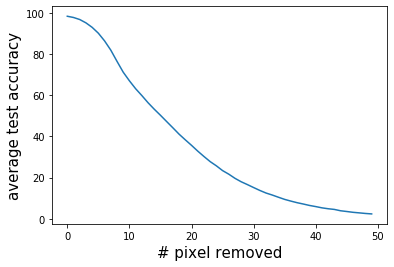

In [108]:
# original test accuracy

count = 0

for i in range(len(dataset)):
    image = dataset.data[i]
    image = image[None, None].type('torch.FloatTensor')
    
    target = dataset.targets[i]
    output = net(image)
    
    if output.argmax().item() == target.item():
        count += 1

# step_acc_list.insert(0, count/len(dataset))

plt.plot(range(total_steps), step_acc_list)
plt.xlabel('# pixel removed', fontsize=15)
plt.ylabel('average test accuracy', fontsize=15)
plt.show()

### score for correct class
50 random samples

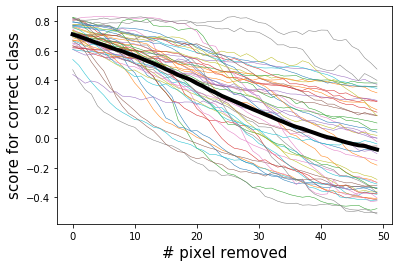

In [107]:
sample_scores = np.array(sample_scores)
mean_score = np.mean(sample_scores, axis=0)

for i in range(sample_num):
    plt.plot(range(total_steps), sample_scores[i], linewidth=0.5)

plt.plot(range(total_steps), mean_score, color='black', linewidth=4)

plt.xlabel('# pixel removed', fontsize=15)
plt.ylabel('score for correct class', fontsize=15)

plt.show()

### selectivity visualization

In [0]:
# original image and gradient

for i in sample_indices:
    image = dataset.data[i]
    image = image[None, None].type('torch.FloatTensor')
    image = Variable(image, requires_grad=True)
    
    target = dataset.targets[i]
    output = net(image)
    grads = VBP.generate_gradients(image, target)
    
    image = image.detach().numpy()

    image = image.squeeze()
    grads = grads.squeeze()

    grads = np.multiply(grads, image)

    index = sample_indices.index(i)

    # sample_images[index].insert(0, image)
    # sample_grads[index].insert(0, grads)

In [0]:
preds = [[] for i in range(sample_num)]

for i in range(sample_num):
    for j in range(3):
        image = torch.tensor(sample_images[i][j])
        image = image[None, None].type('torch.FloatTensor')

        output = net(image)

        preds[i].append(output.argmax().item())

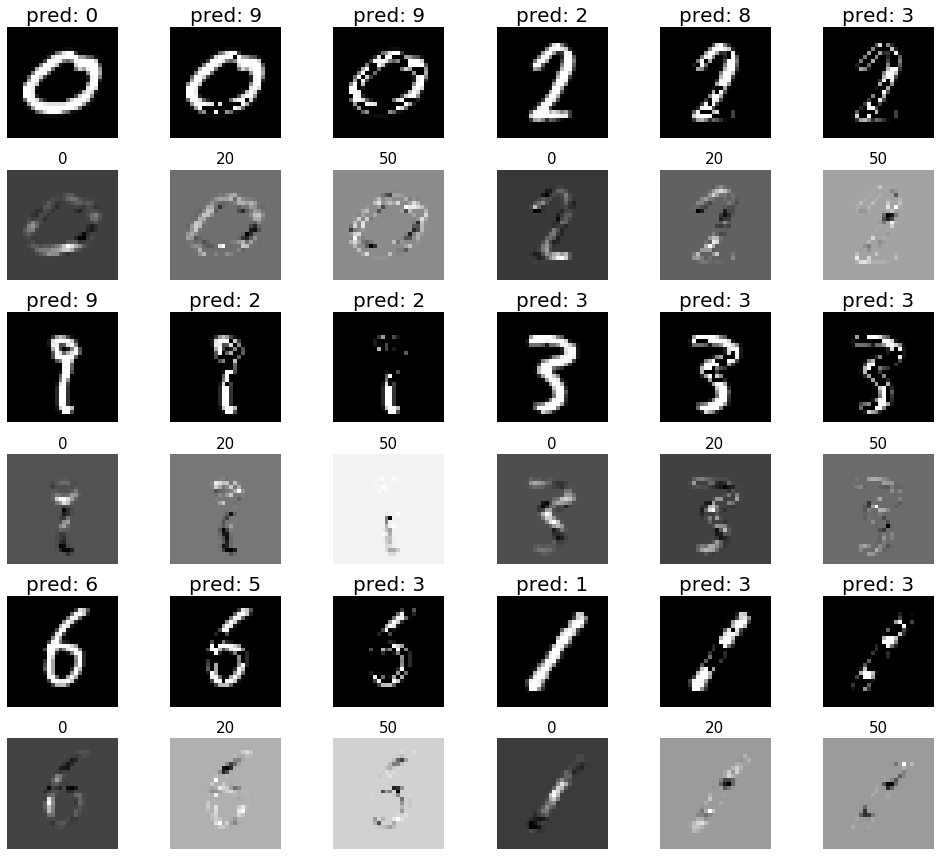

In [106]:
fig = plt.figure(figsize=(14, 12))

row_num = 3
col_num = 2

for i in range(row_num):
    for j in range(col_num):
        index = i * col_num + j
        index = index + 15      # just for good visualization example

        image = sample_images[index]
        grads = sample_grads[index]
        
        ax1 = fig.add_subplot(row_num*2, col_num*3, (2*i*col_num+j)*3+1)
        ax1.imshow(image[0], cmap='gray')
        ax1.axis('off')
        ax1.set_title('pred: ' + str(preds[index][0]), fontsize=20)
        
        ax2 = fig.add_subplot(row_num*2, col_num*3, (2*i*col_num+j)*3+2)
        ax2.imshow(image[1], cmap='gray')
        ax2.axis('off')
        ax2.set_title('pred: ' + str(preds[index][1]), fontsize=20)

        ax3 = fig.add_subplot(row_num*2, col_num*3, (2*i*col_num+j)*3+3)
        ax3.imshow(image[2], cmap='gray')
        ax3.axis('off')
        ax3.set_title('pred: ' + str(preds[index][2]), fontsize=20)

        ax4 = fig.add_subplot(row_num*2, col_num*3, ((2*i+1)*col_num+j)*3+1)
        ax4.imshow(grads[0], cmap='gray')
        ax4.axis('off')
        ax4.set_title('0', fontsize=15)
        
        ax5 = fig.add_subplot(row_num*2, col_num*3, ((2*i+1)*col_num+j)*3+2)
        ax5.imshow(grads[1], cmap='gray')
        ax5.axis('off')
        ax5.set_title('20', fontsize=15)

        ax6 = fig.add_subplot(row_num*2, col_num*3, ((2*i+1)*col_num+j)*3+3)
        ax6.imshow(grads[2], cmap='gray')
        ax6.axis('off')
        ax6.set_title('50', fontsize=15)

plt.tight_layout()
plt.show()